In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [348]:
import warnings
warnings.filterwarnings('ignore')

In [349]:
# dark_palette = ['#3E4095','#9F3E4B','#4D9458','#5D4774','#ADAA27']
# light_palette = ['#A6ABE4','#E3A3A7','#B2D9B8','#C6B9CF','#D9D89F']

In [350]:
df = pd.read_excel('datos.xlsx')
serie = 'v_total'
temp = df[serie]
df = df.loc[:, ~df.columns.str.startswith('ru_')]
df = df.drop(columns=['v_total', 'v_super', 'v_retail', 'v_cowork'])
df = df.drop(columns=['int_ret_sup','int_ret_cow','int_sup_cow','porc_retail','porc_super','porc_cowork'])
df[serie] = temp
df.set_index('mes', inplace=True)
#df = df.asfreq('M')



In [351]:
pipeline_categorical = make_pipeline(
                            OrdinalEncoder(
                                dtype=int,
                                handle_unknown="use_encoded_value",
                                unknown_value=-1,
                                encoded_missing_value=-1
                            ),
                            FunctionTransformer(
                                func=lambda x: x.astype('category'),
                                feature_names_out= 'one-to-one'
                            )
                        )

transformer_exog = make_column_transformer(
                        (
                            pipeline_categorical,
                            make_column_selector(dtype_exclude=np.number)
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                    ).set_output(transform="pandas")

In [352]:
# Create forecaster
forecaster = ForecasterAutoreg(
               regressor = LGBMRegressor(random_state=123
                                         ,min_data_in_bin = 2
                                         ,min_data_in_leaf = 2),
               lags = 2,
               transformer_exog = transformer_exog,
            )

In [353]:
exog_features = [x for x in df.columns if x != serie]

end_train = '2021-08-01'
end_validation = '2022-08-01'
data_train = df.loc[: end_train, :]
data_val   = df.loc[end_train:end_validation, :]
data_test  = df.loc[end_validation:, :]

X_train, y_train = forecaster.create_train_X_y(
                    y = df.loc[:end_validation, serie],
                    exog = df.loc[:end_validation, exog_features]
               )

In [354]:
df.loc[:end_train, 'partition'] = 'train'
df.loc[end_train:end_validation, 'partition'] = 'validation'
df.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = df.reset_index(),
    #x      = 'mes',
    y      = serie,
    color  = 'partition',
    title  = serie,
    width  = 800,
    height = 450
)
fig.update_layout(
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()
data=df.drop(columns='partition')
data.reset_index(drop=False, inplace=True)

In [355]:
#df.loc[:end_validation, serie]

In [356]:
warnings.filterwarnings('ignore')
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [1,2]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data.loc[:end_validation, serie],
                    exog               = data.loc[:end_validation, exog_features],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    initial_train_size = 12, #len(data.loc[:end_train]),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
                )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 11, number of used features: 28
[LightGBM] [Info] Start training from score 8228315.454545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [357]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[serie],
                        exog               = data[exog_features],
                        initial_train_size = len(data.loc[:end_validation]),
                        fixed_train_size   = False,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        verbose            = False
                    )
print(f"Backtest error: {metric:.2f}")

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 19, number of used features: 34
[LightGBM] [Info] Start training from score 7871683.526316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is

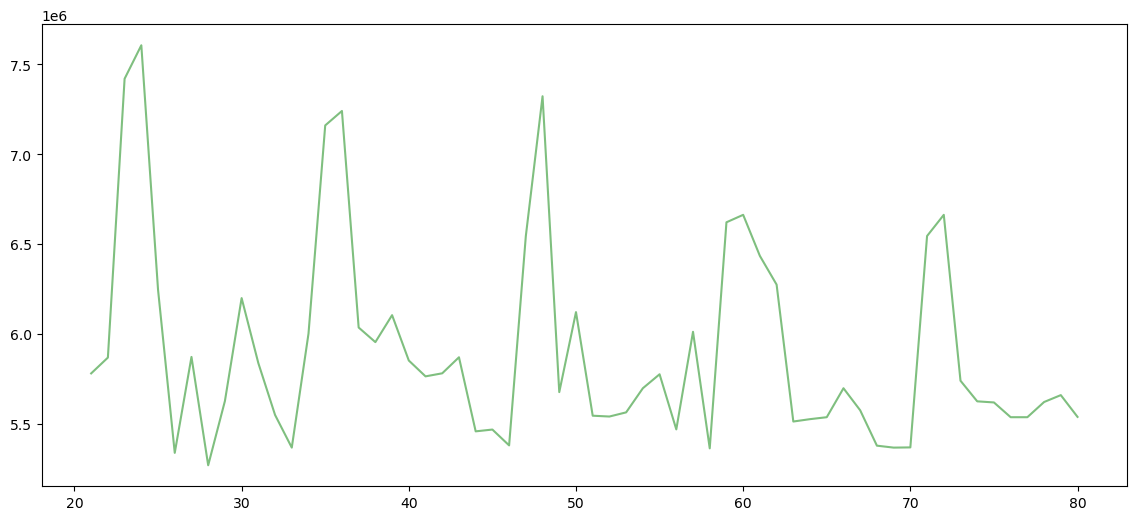

In [360]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plt.plot(predictions['pred'], color='green',label='Predicciones', alpha=0.5)
plt.plot(data_test[serie], color='orange', markersize=6, label='Originales')
plt.show()

In [369]:
predictions['pred'][-13:]

68    5.377062e+06
69    5.366219e+06
70    5.367385e+06
71    6.544399e+06
72    6.662304e+06
73    5.738600e+06
74    5.623886e+06
75    5.617700e+06
76    5.535537e+06
77    5.535537e+06
78    5.620132e+06
79    5.658524e+06
80    5.537227e+06
Name: pred, dtype: float64

In [371]:
print(f"Mean Squared Error (MSE): {mean_squared_error(data_test[serie], predictions['pred'][-13:]):.2e}")
print(f"Mean Absolute Error (MAE):{mean_absolute_error(data_test[serie][-13:], predictions['pred'][-13:]):.2e}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(data_test[serie][-13:], predictions['pred'][-13:])):.2e}")

Mean Squared Error (MSE): 4.72e+11
Mean Absolute Error (MAE):5.93e+05
Root Mean Squared Error (RMSE): 6.87e+05
